In [3]:
#Download the source code of the Mask R-CNN mode & install requests module
!git clone https://github.com/tensorflow/tpu/
!pip install requests 

#Import libraries
from IPython import display
import pandas as pd 
from google.colab import files
import requests
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import itertools
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
import sys
sys.path.insert(0, 'tpu/models/official')
sys.path.insert(0, 'tpu/models/official/mask_rcnn')
import coco_metric
from mask_rcnn.object_detection import visualization_utils

#Load COCO index mapping
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

Cloning into 'tpu'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 9858 (delta 25), reused 29 (delta 15), pack-reused 9798
Receiving objects: 100% (9858/9858), 24.29 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (7063/7063), done.
TensorFlow 1.x selected.


TPU address is grpc://10.110.212.90:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 12368052647893901233),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 10761349135719813295),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 12705475325816968119),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 527087580808093401),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2480857406162392775),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 8744064648217847426),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 4783019546554637815),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 17905357237747627571),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 613632058112

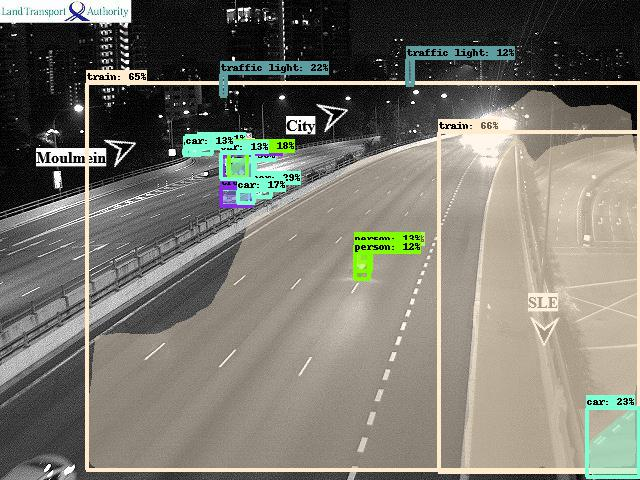

0,

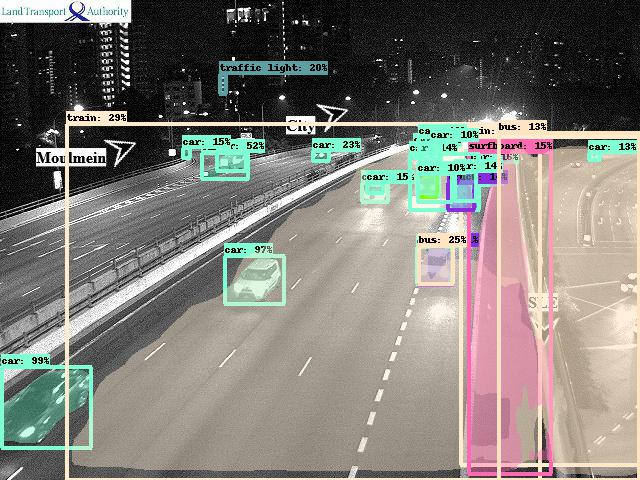

1,

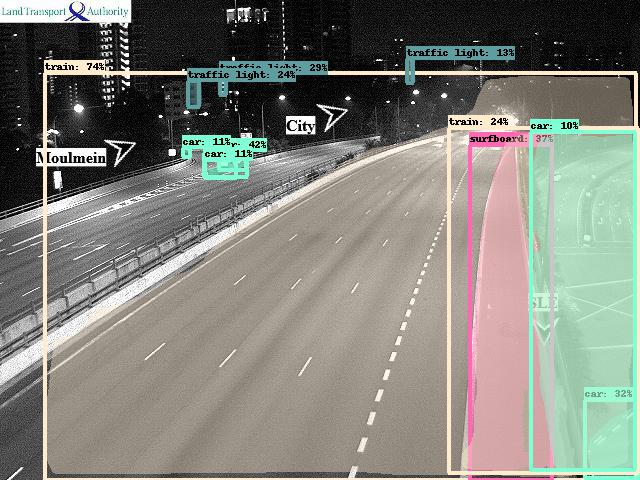

2,

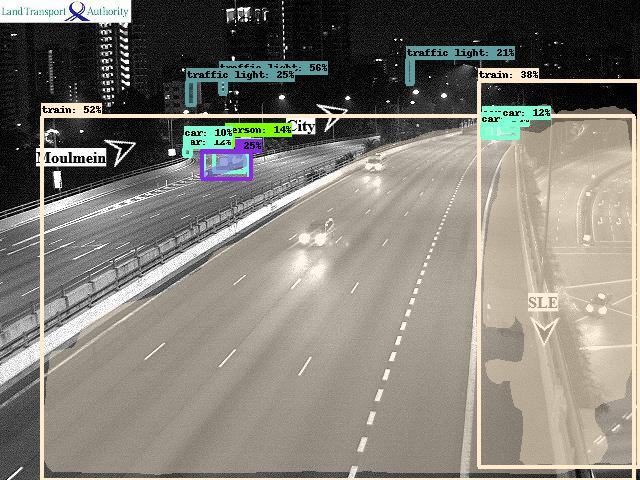

3,

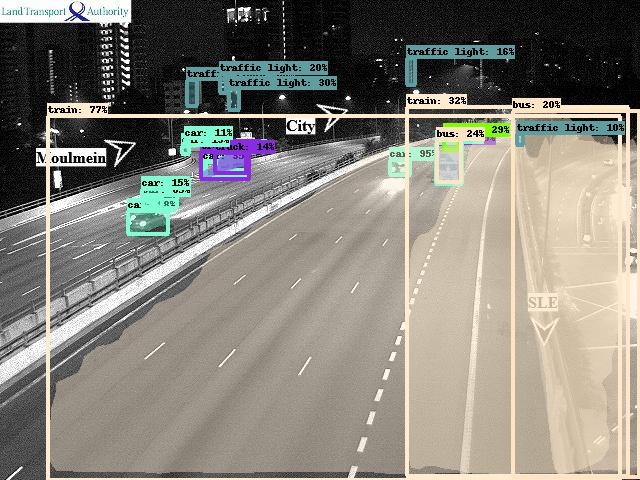

4,

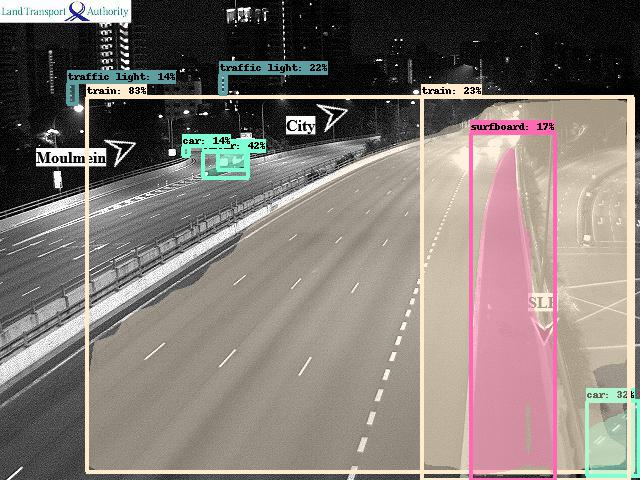

5,

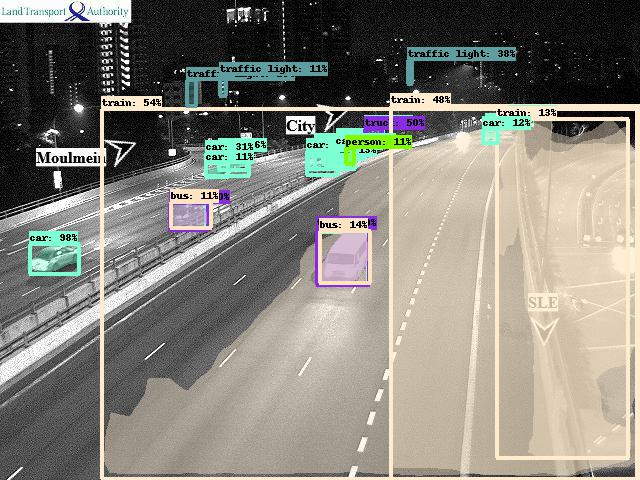

6,

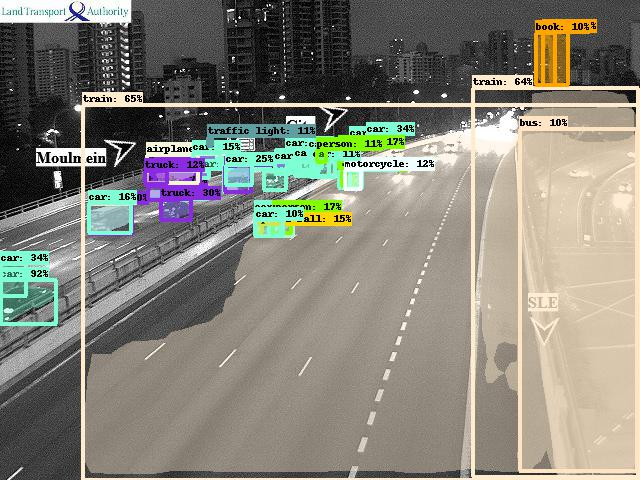

7,

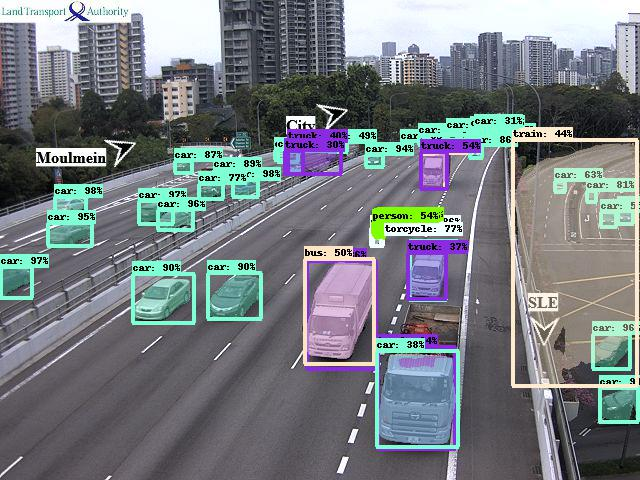

8,

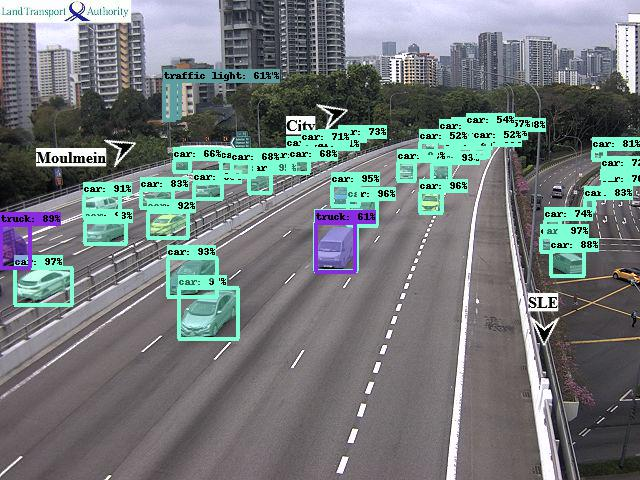

9,

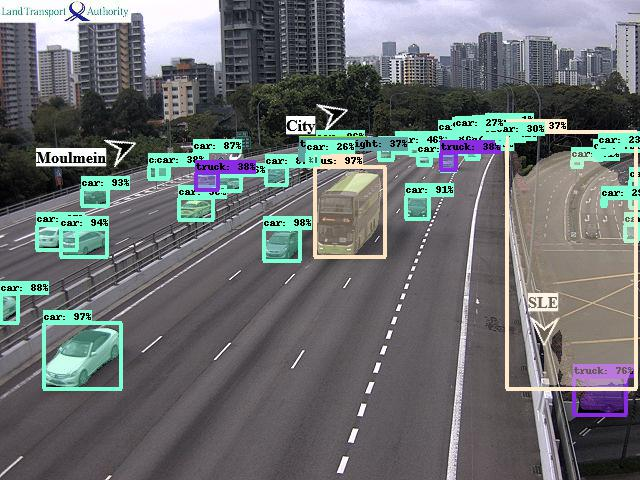

10,

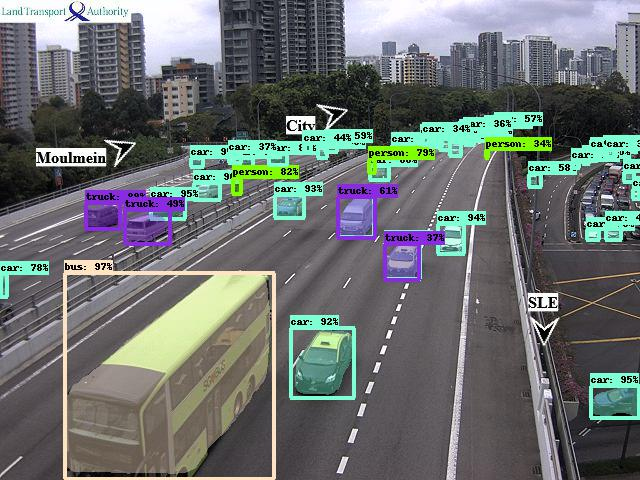

11,

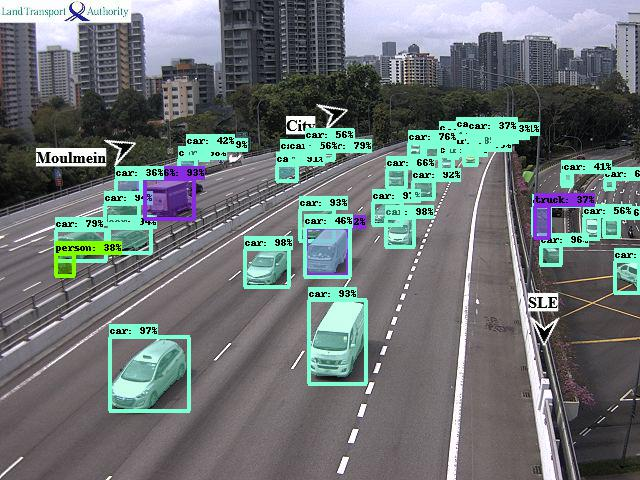

12,

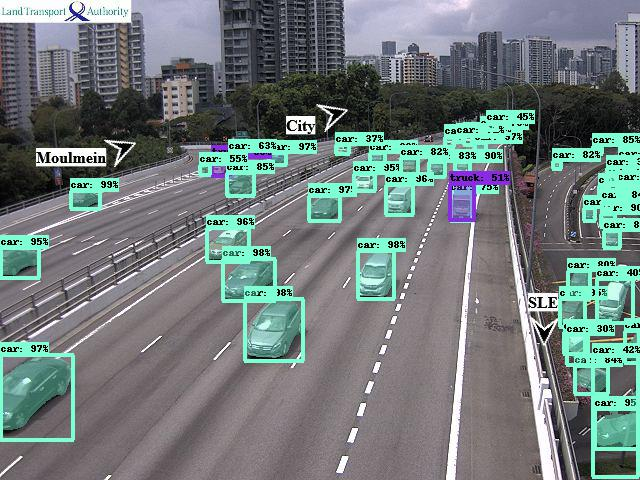

13,

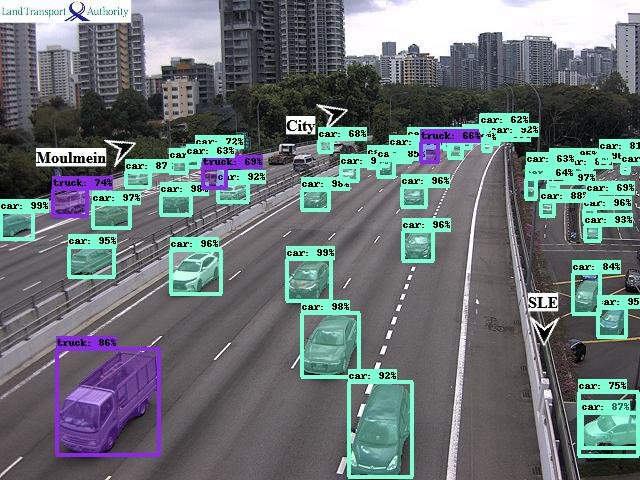

14,

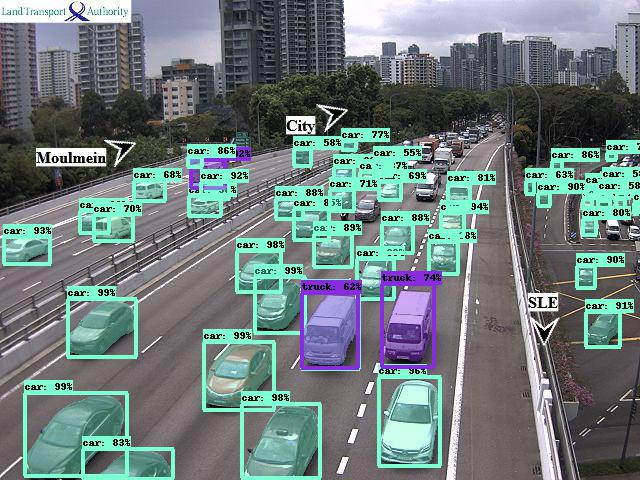

15,

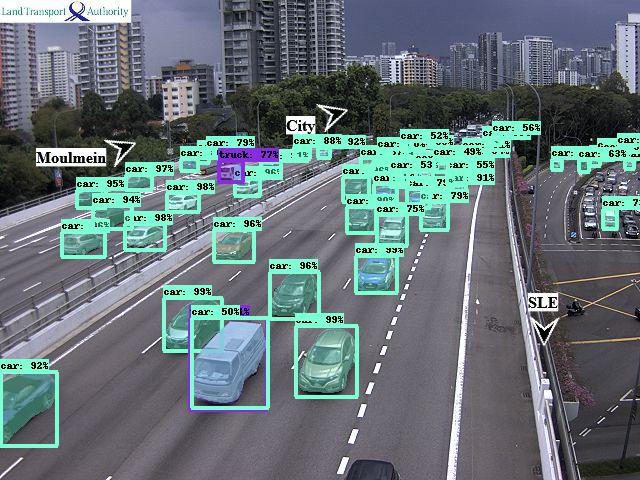

16,

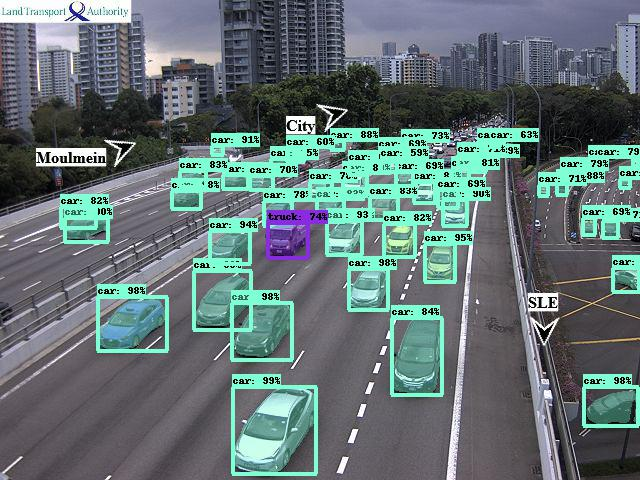

17,

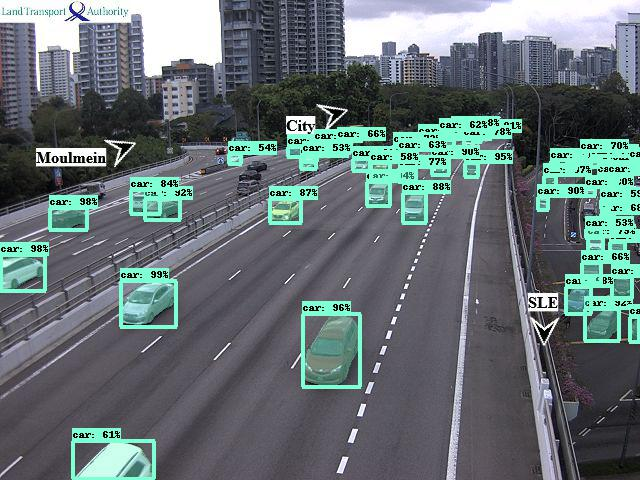

18,

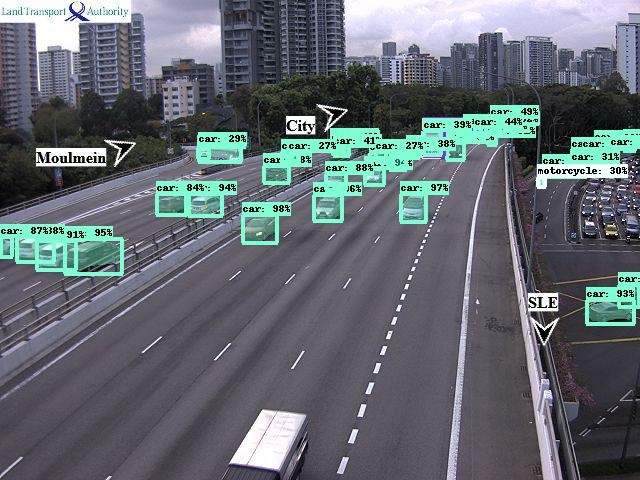

19,

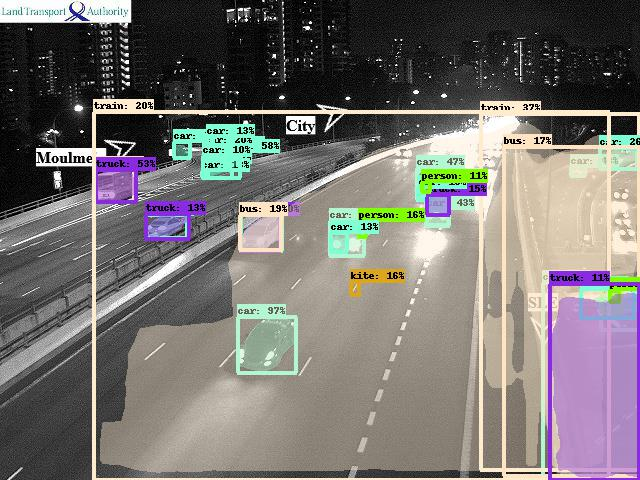

20,

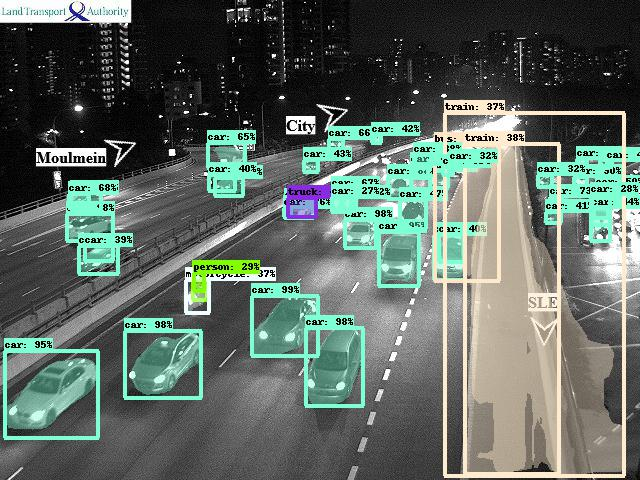

21,

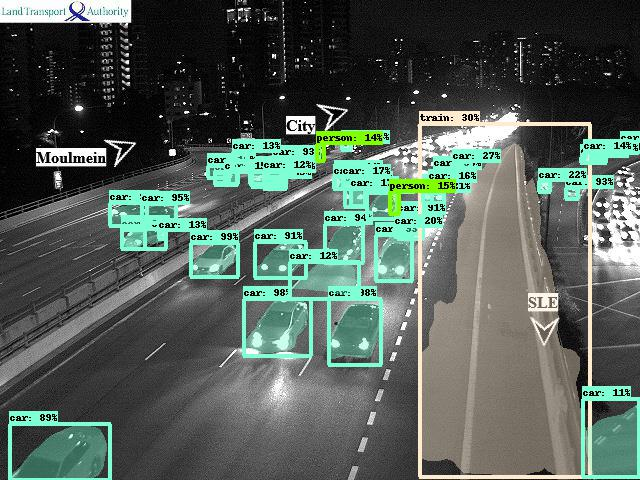

22,

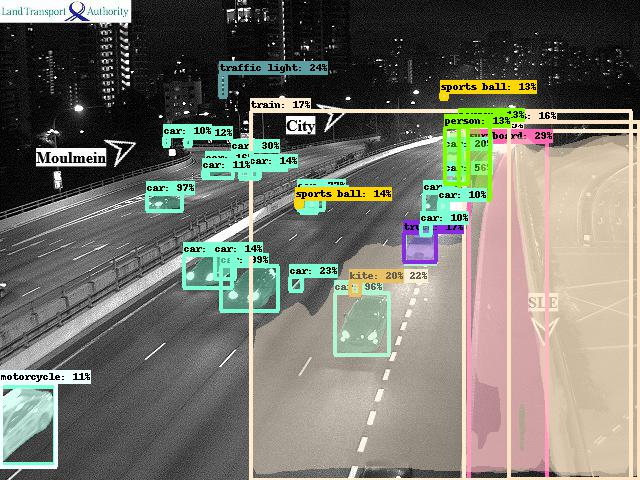

23,    Image_id  ...                                                URL
0          0  ...  https://images.data.gov.sg/api/traffic-images/...
1          0  ...  https://images.data.gov.sg/api/traffic-images/...
2          0  ...  https://images.data.gov.sg/api/traffic-images/...
3          0  ...  https://images.data.gov.sg/api/traffic-images/...
4          0  ...  https://images.data.gov.sg/api/traffic-images/...
..       ...  ...                                                ...
50        23  ...  https://images.data.gov.sg/api/traffic-images/...
51        23  ...  https://images.data.gov.sg/api/traffic-images/...
52        23  ...  https://images.data.gov.sg/api/traffic-images/...
53        23  ...  https://images.data.gov.sg/api/traffic-images/...
54        23  ...  https://images.data.gov.sg/api/traffic-images/...

[1809 rows x 6 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
df_app = []
#Create a Tensorflow session to run the inference. You can either connect to a TPU or a normal CPU backend.
use_tpu = True 
if use_tpu:
  import os
  import pprint 

  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime;'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU address is', TPU_ADDRESS)

  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  print('TPU devices:')
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph=tf.Graph())

#Loading the coco pretrained seved model from the public GCS bucket
saved_model_dir = 'gs://cloud-tpu-checkpoints/mask-rcnn/1555659850' 
_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

#Import a previous generated and uploaded csv from dropbox 
#Remember to set 1 instead of 0 in the last part of the URL
df = pd.read_csv("your_link=1",
                 sep = ',',error_bad_lines=False)
images = df.loc[:,'Image']
cam_id = df.loc[:,'Cam_id']
timestamp_sg_time = df.loc[:,'Timestamp_sg_time']
url = df.loc[:,'Image']

## Loading each image to apply the R-CNN
i = 1
for i in range(len(images)):
  site = images[i]
  img_data = requests.get(site).content
  with open('image_name.jpg', 'wb') as handler:
      handler.write(img_data)

  image_path = 'image_name.jpg'

  with open(image_path, 'rb') as f:
    np_image_string = np.array([f.read()])
    
  image = Image.open(image_path)
  width, height = image.size
  np_image = np.array(image.getdata()).reshape(height, width, 3).astype(np.uint8)

  #display.display(display.Image(image_path, width=1024)) #Image preview

  #Perform image segmentation and retrieve the predictions 
  num_detections, detection_boxes, detection_classes, detection_scores,detection_masks, image_info = session.run(
      ['NumDetections:0', 'DetectionBoxes:0', 'DetectionClasses:0',
       'DetectionScores:0', 'DetectionMasks:0', 'ImageInfo:0'],
      feed_dict={'Placeholder:0': np_image_string})

  num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
  detection_boxes = np.squeeze(detection_boxes * image_info[0, 2], axis=(0,))[0:num_detections]
  detection_scores = np.squeeze(detection_scores, axis=(0,))[0:num_detections]
  detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
  instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]
  ymin, xmin, ymax, xmax = np.split(detection_boxes, 4, axis=-1)
  processed_boxes = np.concatenate([xmin, ymin, xmax - xmin, ymax - ymin], axis=-1)
  segmentations = coco_metric.generate_segmentation_from_masks(instance_masks, processed_boxes, height, width)

  #Visualze the detections results and print a dataframe generated by detection class and detection score
  max_boxes_to_draw = 50  
  min_score_thresh = 0.1  
  image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
      np_image,
      detection_boxes,
      detection_classes,
      detection_scores,
      category_index,
      instance_masks=segmentations,
      use_normalized_coordinates=False,
      max_boxes_to_draw=max_boxes_to_draw,
      min_score_thresh=min_score_thresh)
  output_image_path = 'test_results.jpg'
  Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
  display.display(display.Image(output_image_path, width=1024)) #Processed image preview
  df = pd.DataFrame(list(zip(itertools.repeat(i),itertools.repeat(cam_id[i]),
                             detection_classes, detection_scores,
                             itertools.repeat(timestamp_sg_time[i]),
                             itertools.repeat(url[i]))), 
          columns =['Image_id', 'Cam_ID','Detection_Class',
                    'Detection_Score','Timestamp_sg_time'
                    ,'URL'])

  df_app.append(df)
  print(i,end=',')
  if (i == 53 or i == 102):
    print("\n")
#Download a simple dataframe with the detections classes and detection scores 
df_simple = pd.concat(df_app)
#df_simple.set_index('Id', inplace=True)
print(df_simple)
df_simple.to_csv('Wed1-20-20.csv') 
files.download('Wed1-20-20.csv')